# CASSANDRA
Now that we've got our features tidied and sorted out, let's kick-start the modelling process.

---

## Problem Statement (A recap)
Timing is absolutely key in financial markets. The ability to predict market peaks (both near-term and long-term) can help protect investors from significant drawdowns and elevated volatility. Of course, most of us do not have the luck of being endowed with such prophetic abilities. However, we may be able to leverage on the advances made in machine learning to create a more advanced barometer of risk (especially for US equity markets) to help investors navigate through the noise.

We define a *pullback* as whether the S&P 500 index will be lower in a month's time (i.e. rolling 4 weeks). The model we are looking to build should be able to do the following:
* Predict the likelihood that the S&P 500 index will fall over the coming month
* Explain which variables matter and how they interact

## Organisation of codebooks
1. Data collection, EDA, Feature Engineering
2. **Pre-processing, model tuning and conclusions** <-- You're here

In [1]:
# Import libraries
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
                             plot_confusion_matrix, classification_report, roc_auc_score, roc_curve,plot_roc_curve, ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
                              AdaBoostClassifier, VotingClassifier, BaggingClassifier)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from catboost import CatBoostClassifier

# Import our custom module
import SIREN_func

# Importing the most important module
from pycaret.classification import *

C:\Users\cheon\anaconda3\envs\siren\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
 # Ensuring the notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Customising aesthetics
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_palette('tab20c')

## Pre-processing, Modelling

Let's import our selected features from the previous codebook.

In [4]:
# Import our cleaned dataset from our previous script
full = pd.read_pickle('../data/full.pkl')

We will first need to create our **target variable** which is defined as whether the S&P 500 index will be lower in a month's time (i.e. rolling 4 weeks) - Binary (1 or 0). We will use a *lambda* function for that. We will train the model from the period of 2005-2018 and use 2019-2021 as our testing set.

You could argue that we could exclude 2020 given the unusual market dnamics of the ongoing COVID-19 pandemic but I've decided to leave it in anyway.

In [5]:
# Creating our target variable
full['spx_class'] = full['spx'].copy().apply(lambda x: 1 if x < 0 else 0)

# Dropping unneccessary columns
combined = full.copy().drop(columns=['sx5e', 'ftse100', 'tpx', 'msci_axj', 'msci_acw']).reset_index()

In [131]:
# Creating our train split
train = combined.loc[combined['date'].dt.year < 2019]
train.dropna(inplace=True)

# Forming our test split
test = combined.loc[(combined['date'].dt.year >= 2019) & (combined['date'].dt.year <= 2022)]
test.dropna(inplace=True)

for_plotting = combined.loc[(combined['date'].dt.year >= 2019)]

Since our focus is on decision trees, we will not be normalising our data. We will however fix the imbalanced nature of our dataset and remove features with high multicollinearity. We'll be leveraging on *pycaret* here.

In [132]:
# Setting up our pycaret environment
pyc = setup(train, target='spx_class', test_data=test, feature_interaction=False, session_id=42, remove_multicollinearity=True, multicollinearity_threshold=0.7, \
    normalize=False, fix_imbalance=True, ignore_features=['date', 'spx', 'fdtr'], data_split_shuffle=False, fold_strategy='timeseries', fold=20, remove_outliers=False)

,Description,Value
0,session_id,42
1,Target,spx_class
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(679, 65)"
5,Missing Values,0
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


In [173]:
# Comparison of selected models
comparison = compare_models(cross_validation=False, probability_threshold=0.5, sort='AUC', include=['dummy', 'xgboost', 'catboost', 'ada', 'lightgbm', 'dt', 'rf', 'et'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.6788,0.6525,0.3600,0.4615,0.4045,0.1892,0.1919,0.9000
lightgbm,Light Gradient Boosting Machine,0.6970,0.6353,0.3400,0.5000,0.4048,0.2113,0.2184,0.4800
catboost,CatBoost Classifier,0.6788,0.6238,0.1800,0.4286,0.2535,0.0905,0.1043,10.7100
ada,Ada Boost Classifier,0.6364,0.6191,0.3600,0.3913,0.3750,0.1192,0.1194,0.5500
dt,Decision Tree Classifier,0.5636,0.5965,0.6800,0.3778,0.4857,0.1574,0.1782,0.0800
et,Extra Trees Classifier,0.6606,0.5185,0.1000,0.3125,0.1515,0.0054,0.0068,0.2800
rf,Random Forest Classifier,0.6727,0.5167,0.1800,0.4091,0.2500,0.0795,0.0905,0.4100
dummy,Dummy Classifier,0.3030,0.5000,1.0000,0.3030,0.4651,0.0000,0.0000,0.0400


## Model selection

We'll go with *lightgbm* given the reasonably high accuracy + precision. It is also way faster.

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. Our dataset may be considered small here though!

In [134]:
# Creating our model
model = create_model('lightgbm', cross_validation=True, probability_threshold=0.5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7500,0.6667,0.0000,0.0000,0.0000,-0.1327,-0.1384
1,0.5938,0.5508,0.3125,0.7143,0.4348,0.1875,0.2268
2,0.5312,0.6125,0.5500,0.6471,0.5946,0.0476,0.0485
3,0.3438,0.4271,0.2083,0.7143,0.3226,-0.0244,-0.0436
4,0.2812,0.5893,1.0000,0.1481,0.2581,0.0515,0.1627
5,0.6250,0.4242,0.0000,0.0000,0.0000,-0.0608,-0.1300
6,0.6875,0.8229,0.8571,0.4000,0.5455,0.3522,0.4118
7,0.6250,0.7383,0.3750,0.7500,0.5000,0.2500,0.2887
8,0.5000,0.5700,0.5556,0.2941,0.3846,0.0266,0.0305
9,0.2188,0.1498,0.0769,0.0714,0.0741,-0.6000,-0.6012


In [179]:
# Tuning our model
tuned_model = tune_model(model, optimize="Recall", choose_better=True, return_tuner=False, n_iter=10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.1562,0.5000,1.0000,0.1562,0.2703,0.0000,0.0000
1,0.5000,0.5000,1.0000,0.5000,0.6667,0.0000,0.0000
2,0.6250,0.5000,1.0000,0.6250,0.7692,0.0000,0.0000
3,0.7500,0.5000,1.0000,0.7500,0.8571,0.0000,0.0000
4,0.1250,0.5000,1.0000,0.1250,0.2222,0.0000,0.0000
5,0.3438,0.5000,1.0000,0.3438,0.5116,0.0000,0.0000
6,0.7812,0.7886,0.8571,0.5000,0.6316,0.4909,0.5270
7,0.7188,0.7148,0.8750,0.6667,0.7568,0.4375,0.4606
8,0.5312,0.6184,0.6667,0.3333,0.4444,0.1111,0.1314
9,0.3438,0.1660,0.1538,0.1667,0.1600,-0.3770,-0.3779


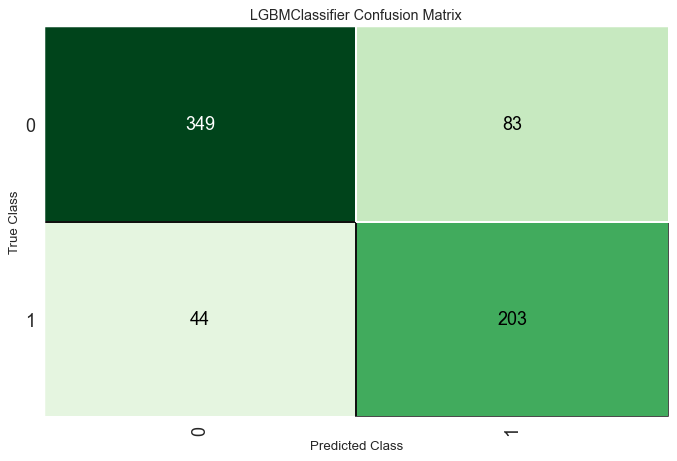

In [184]:
# Plotting our confusion matrix on test data
plot_model(tuned_model, plot='confusion_matrix', use_train_data=True, scale=1.2)

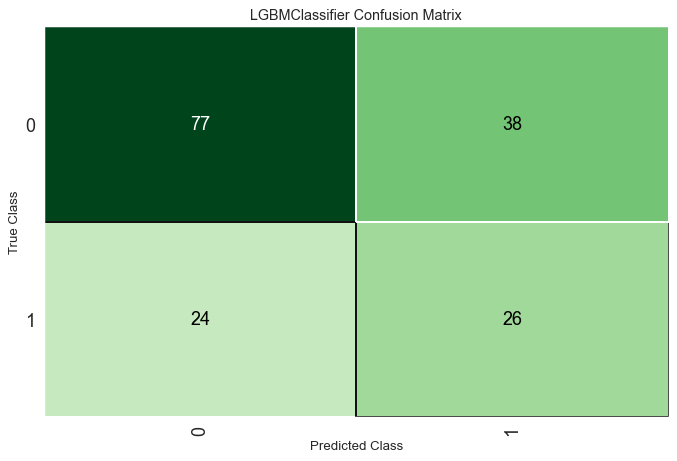

In [180]:
# Plotting our confusion matrix on test data
plot_model(tuned_model, plot='confusion_matrix', scale=1.2)

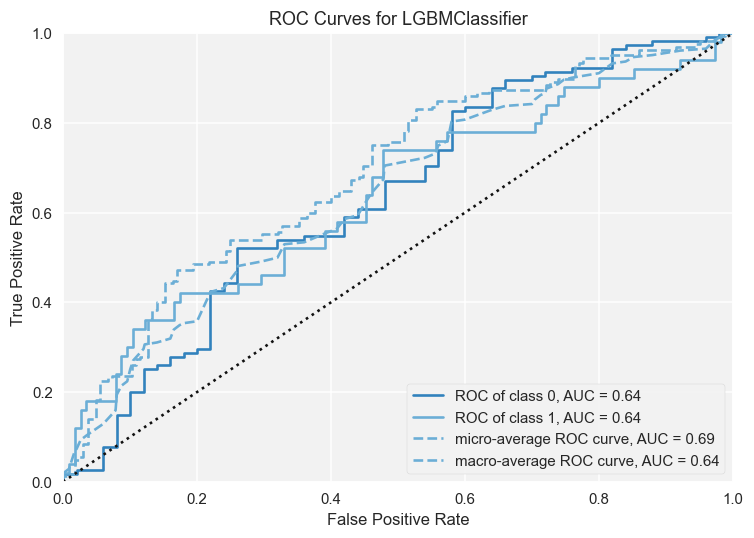

In [181]:
plot_model(tuned_model, plot='auc', scale=1.5)

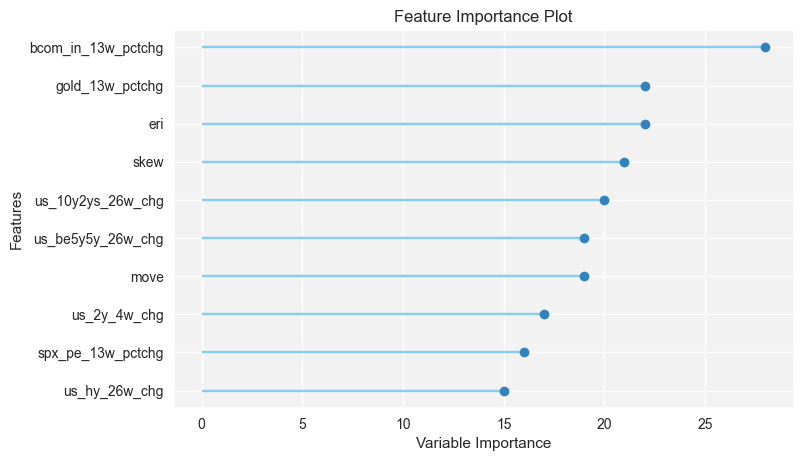

In [182]:
# Visualising our top features
plot_model(tuned_model, plot='feature')

## Explaining CASSANDRA

SHAP values highlight the value to which a feature has contributed to the model’s prediction; It makes correlations transparent. Interpretability of a model is of utmost importance in finance; Keep it simple!

Our focus is on the top features: Industrial metals + gold 13-week % change, MOVE / SKEW indices, earnings revision indices, multiple re-ratings

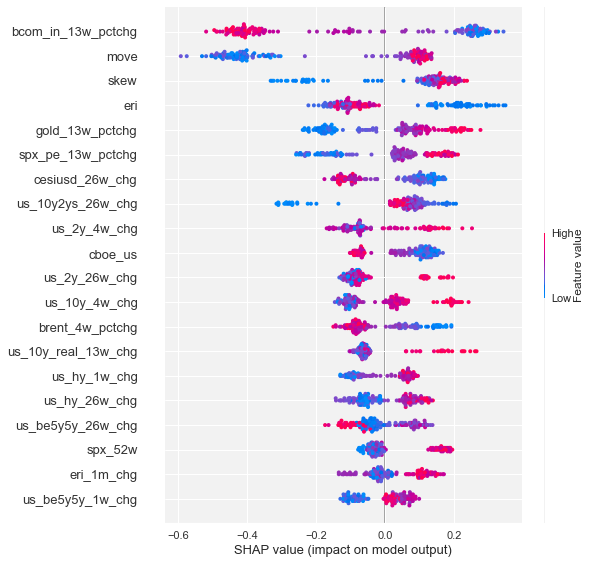

In [183]:
# Analysing the predictions generated from our train model
interpret_model(tuned_model, plot='summary')

### Quant insights

**Don't shrug off fundamentals**: Earnings revision (eri) and economic surprise indices (cesiusd); US economic data has been surprising to the upside… but that has raised fears of a more hawkish Fed… An earnings revision ratio below 0 - typically increases the likelihood of a decline in equities

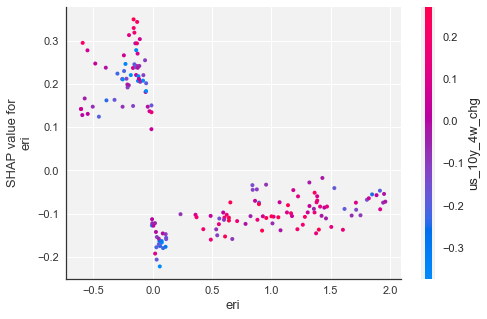

In [142]:
# Dependence on earnings revision(s)
interpret_model(tuned_model, plot="correlation", feature='eri')

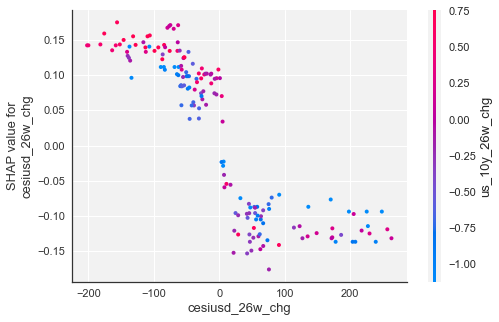

In [143]:
# Dependence on economic conditions
interpret_model(tuned_model, plot="correlation", feature='cesiusd_26w_chg')

**Watch the Fed**: Given the flood of liquidity on the back of QE over the past decade, whatever the Fed decides to do over the coming months is key; Higher rates = Lower multiples = Tighter liquidity.

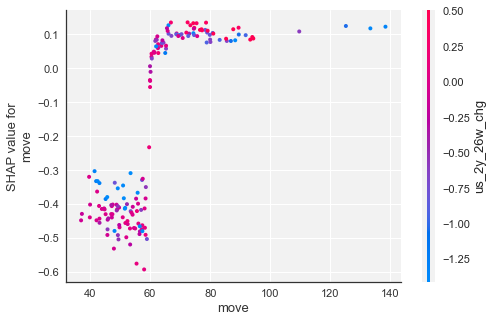

In [140]:
# Dependence on MOVE
interpret_model(tuned_model, plot="correlation", feature='move')

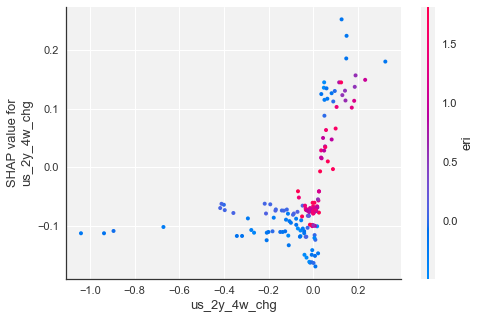

In [119]:
# Dependence on 2-year US yield trajectories
interpret_model(tuned_model, plot="correlation", feature='us_2y_4w_chg')

**Pay attention to the SKEW**: The SKEW index is often overlooked by most people (myself included). It is a measure of perceived tail risk in the S&P 500 based on deep OTM options. Unlike other sentiment indicators, the direction of travel does not appear to be contrarian.

Whenever the cost of tail-risk protection rises, CASSANDRA believes there is an increased likelihood of a drawdown in equity markets

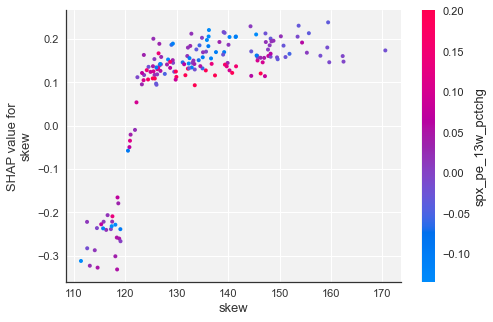

In [141]:
# Dependence on SKEW
interpret_model(tuned_model, plot="correlation", feature='skew')

**Commodities and Reflation**: They’re known to be important drivers of equity markets contemptuously. A fall in the price of industrial metals increases the likelihood of a drawdown in equity markets whereas the safe-haven properties of gold are illustrated below.

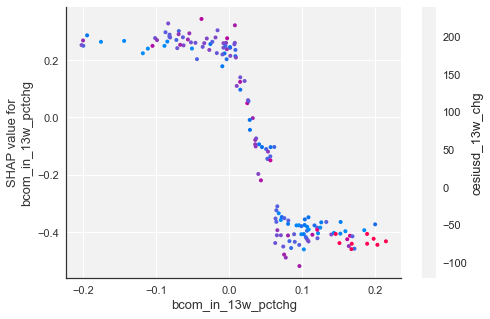

In [70]:
# Dependence on industrial metals
interpret_model(tuned_model, plot="correlation", feature='bcom_in_13w_pctchg')

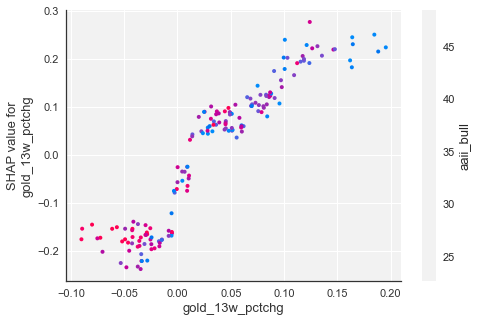

In [144]:
# Dependence on gold
interpret_model(tuned_model, plot="correlation", feature='gold_13w_pctchg')

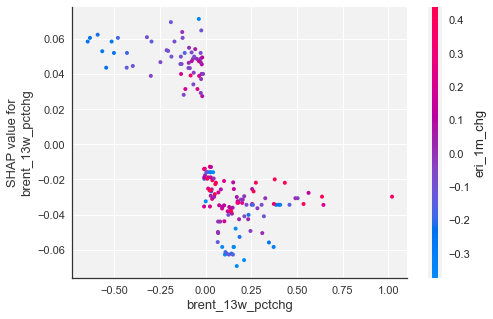

In [145]:
# Dependence on Brent crude oil
interpret_model(tuned_model, plot="correlation", feature='brent_13w_pctchg')

## Generating our predictions

In [147]:
#Generate predictions
predictions = predict_model(tuned_model, verbose=False, raw_score=True, data=for_plotting.drop(columns=['spx_class']))

In [158]:
# Concatenating our datset for charting
predictions_df = pd.concat([for_plotting.reset_index().drop(columns="index"), predictions.reset_index().drop(columns=["index"])['Score_1']], axis=1, join="inner")

# Converting to whole numbers
predictions_df['Score_1'] = predictions_df['Score_1']*100
predictions_df.tail(10)

,date,eri,eri_1m_chg,eri_3m_chg,cesiusd_1w_chg,cesiusd_4w_chg,cesiusd_13w_chg,cesiusd_26w_chg,us_hy_1w_chg,us_hy_4w_chg,...,vix,move,skew,aaii_bull,cboe_us,spx_rsi14d,spx_pct_rsi14d_above70,fdtr,spx_class,Score_1
159,2022-01-21,0.641484,0.048198,-0.523182,-0.5,-27.0,29.2,-12.1,0.192654,0.295568,...,28.85,81.03,136.18,21.0,0.82,44.18,1.19,0.25,1,43.37
160,2022-01-28,0.609039,-0.013586,-0.408483,0.7,-22.2,13.4,11.1,0.332373,0.623171,...,27.66,85.29,132.96,23.1,0.72,45.98,2.18,0.25,1,34.99
161,2022-02-04,0.557014,-0.084444,-0.338130,-1.9,-8.2,-2.8,-1.2,-0.032916,0.437319,...,23.22,87.68,129.29,26.5,0.61,49.52,2.77,0.25,1,39.86
162,2022-02-11,0.489071,-0.164370,-0.292387,4.5,2.8,-10.8,29.0,0.253234,0.745345,...,27.36,94.03,126.81,24.4,0.64,45.67,2.57,0.25,1,31.55
163,2022-02-18,0.425675,-0.215809,-0.244037,16.3,19.6,-15.8,53.0,-0.028368,0.524323,...,27.75,94.36,128.36,19.2,0.73,42.63,0.59,0.25,0,38.10
164,2022-02-25,0.368838,-0.240201,-0.231249,25.6,44.5,15.4,91.3,-0.113225,0.078725,...,27.59,93.34,132.51,23.4,0.57,44.67,1.19,0.25,0,42.37
165,2022-03-04,0.317750,-0.239264,-0.225217,17.3,63.7,25.5,113.1,0.227236,0.338877,...,31.98,131.82,134.98,30.4,0.67,42.16,8.32,0.25,0,32.63
166,2022-03-11,0.262344,-0.226727,-0.272076,-4.8,54.4,19.3,113.7,0.183428,0.269071,...,30.75,99.03,130.70,24.0,0.66,37.14,1.78,0.25,0,33.12
167,2022-03-18,0.225198,-0.200477,-0.335376,-7.3,30.8,21.1,92.3,-0.246288,0.051151,...,23.87,91.77,136.64,22.5,0.45,50.36,3.76,0.50,0,38.39
168,2022-03-25,0.193627,-0.175210,-0.399658,9.4,14.6,32.8,87.2,-0.282165,-0.117789,...,20.81,125.27,140.26,32.8,0.50,53.61,7.72,0.50,0,45.71


In [122]:
# Import our cleaned dataset from our previous script
eq_indices = pd.read_pickle('../data/eq_indices.pkl')

**Current readings**
The latest readings suggest the risk of a market decline is now at around 40% (Rising slightly in recent weeks). The big criticism here is that CASSANDRA did not manage to predict the broad risk-off moves across markets, spurred by Russia's invasion of Ukraine.

The readings prior to the invasion were fairly mixed....

In [157]:
interpret_model(tuned_model, plot="reason", observation=161)

In [163]:
# Calculating daily drawdown
eq_indices['spx_dd'] = (eq_indices['spx']/eq_indices['spx'].cummax()-1)*100

date
2005-07-01     0.000000
2005-07-08     0.000000
2005-07-15     0.000000
2005-07-22     0.000000
2005-07-29     0.000000
                ...    
2022-02-25    -8.004943
2022-03-04    -9.175272
2022-03-11   -11.788686
2022-03-18    -6.358551
2022-03-25    -4.681317
Name: spx_dd, Length: 874, dtype: float64

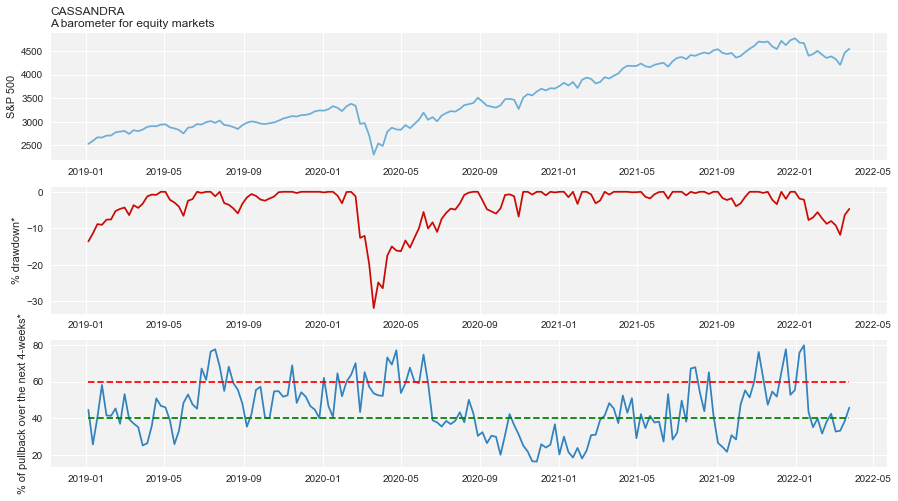

In [170]:
fig, ax = plt.subplots(3, figsize=(15, 8))

ax0 = sns.lineplot(data=eq_indices["2019-01-01":], ax=ax[0], x='date', y='spx', color=sns.color_palette('tab20c')[1])
ax0.set_title("CASSANDRA\nA barometer for equity markets", loc="left")
ax0.set_xlabel("")
ax0.set_ylabel("S&P 500")

ax1 = sns.lineplot(data=eq_indices["2019-01-01":], ax=ax[1], x='date', y='spx_dd', color="r")
ax1.set_xlabel("")
ax1.set_ylabel("% drawdown*")

ax2 = sns.lineplot(data=predictions_df, ax=ax[2], x='date', y='Score_1')
ax2 = sns.lineplot(data=predictions_df, ax=ax[2], x='date', y=60, color="red", linestyle="--")
ax2 = sns.lineplot(data=predictions_df, ax=ax[2], x='date', y=40, color="green", linestyle="--")
ax2.set_xlabel("")
ax2.set_ylabel("% of pullback over the next 4-weeks*")
plt.show()

## Further improvements to consider
I've had a lot of fun dipping into the data and playing around with the models I've learnt in class. While CASSANDRA will likely not work in an almost-efficient market, this was a great learning experience.

* Benoit Mandlebrot's fractal market hypothesis (Fractal Dimensions) could be incorporated here (maybe in smaller timeframes).
* A generic risk-on-risk-off indicator could be developed in conjunction with CASSANDRA via PCA decomposition; If PC1 exceeds 50% and past x-day returns have been negative, we can safely assume the risk-off regime could continue for a while longer
* More analysis around technical oscillators
* A more timely geopolitcial uncertainty proxy could be introduced here (maybe mining text sentiment from key financial agencies)

---